In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('bmh')
plt.rc('font', family='NanumBarunGothic')
warnings.filterwarnings('ignore')
plt.rcParams['axes.unicode_minus'] = False
path='/content/drive/MyDrive/lstm_dacon/'
df= pd.read_csv(path+"train.csv")
answer = pd.read_csv(path+"sample_submission.csv")

In [3]:
"""
일조합과 일사합은 태양의 빛과 관련된 용어로, 기상학에서 중요한 요소입니다.

일조합(日照合): 일조합은 특정 장소에서 실제로 태양 빛이 도달하는 시간의 총합을 말해요.
기상 관측에서는 보통 하루 동안 태양 빛이 땅에 닿는 시간을 측정하며, 이를 일조시간이라고 합니다.
그리고 일정 기간 동안의 일조시간을 모두 더한 것이 일조합이죠.
일사합(日射合): 일사합은 일정 기간 동안 태양으로부터 받은 총 일사 에너지의 양을 말합니다.
일사량은 태양 복사 에너지가 지표면에 닿는 양을 말하고,
이를 측정하는 것은 태양의 에너지가 실제로 얼마나 지구에 도달했는지를 알려주는 중요한 지표가 됩니다.
일조율 : 흐림정도
"""

df.isna().sum()

일시          0
최고기온        3
최저기온        3
일교차         4
강수량     13861
평균습도        0
평균풍속        4
일조합       118
일사합      4862
일조율       366
평균기온        0
dtype: int64

In [4]:
null_cols = ['최고기온', '최저기온','평균풍속']
for col in null_cols:
  df[col].interpolate(method='linear', inplace=True)

In [5]:
df['일교차']=df['최고기온']-df['최저기온']
df['강수량']=df['강수량'].fillna(0)

In [6]:
for i in df[df[['일조율']].isnull().any(axis=1)].index:
    df.loc[i,'일조율']=df[df['일조합']==df.loc[i]['일조합']]['일조율'].median()
for i in df[df[['일조합']].isnull().any(axis=1)].index:
    df.loc[i,'일조합']=df[df['일조율']==df.loc[i]['일조율']]['일조합'].median()
for i in df[df[['일사합']].isnull().any(axis=1)].index:
    df.loc[i,'일사합']=df[df['일조합']==df.loc[i]['일조합']]['일사합'].median()

In [7]:
df.isna().sum()

일시      0
최고기온    0
최저기온    0
일교차     0
강수량     0
평균습도    0
평균풍속    0
일조합     0
일사합     0
일조율     0
평균기온    0
dtype: int64

          최고기온      최저기온       일교차       강수량      평균습도      평균풍속       일조합  \
최고기온  1.000000  0.962798  0.182015  0.127748  0.306833 -0.227326  0.065583   
최저기온  0.962798  1.000000 -0.090465  0.213358  0.442913 -0.185559 -0.117416   
일교차   0.182015 -0.090465  1.000000 -0.305563 -0.480861 -0.162586  0.668961   
강수량   0.127748  0.213358 -0.305563  1.000000  0.380712  0.051768 -0.333036   
평균습도  0.306833  0.442913 -0.480861  0.380712  1.000000 -0.111971 -0.595641   
평균풍속 -0.227326 -0.185559 -0.162586  0.051768 -0.111971  1.000000  0.052960   
일조합   0.065583 -0.117416  0.668961 -0.333036 -0.595641  0.052960  1.000000   
일사합   0.378384  0.215384  0.610775 -0.292325 -0.445410  0.037713  0.814315   
일조율  -0.122833 -0.294322  0.618291 -0.341010 -0.637874  0.057575  0.966441   
평균기온  0.989548  0.989342  0.046904  0.174269  0.376363 -0.209078 -0.030099   

           일사합       일조율      평균기온  
최고기온  0.378384 -0.122833  0.989548  
최저기온  0.215384 -0.294322  0.989342  
일교차   0.610775  0.618291  0.04

<Axes: >

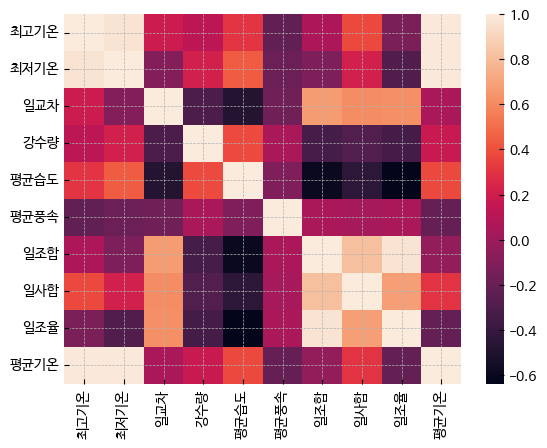

In [8]:
print(df.iloc[:,1:].corr())
sns.heatmap(df.iloc[:,1:].corr())

In [9]:
df['월'] = df['일시'].str[5:7]

In [10]:
# 월을 기반으로 계절 생성
def create_season(month):
    if month in ['03', '04', '05']:
        return '봄'
    elif month in ['06', '07', '08']:
        return '여름'
    elif month in ['09','10', '11']:
        return '가을'
    else:
        return '겨울'

# '월' 컬럼으로부터 '계절' 컬럼 생성
df['계절'] = df['월'].apply(create_season)

# One-Hot Encoding 생성
df_encoded = pd.get_dummies(df, columns=['계절'])

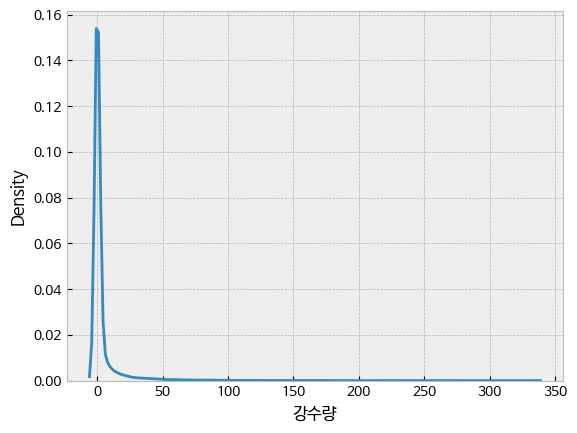

In [11]:
#강수량 확인
sns.kdeplot(x=df_encoded['강수량'])
plt.show()

In [12]:
#https://blog.naver.com/chummilmil99/223094140026
print(len(sorted(df_encoded[df_encoded['강수량'] > 3]['강수량'])))
def create_rain(rain):
    if rain > 3:
      return 1
    else:
      return 0
df['강수량'] = df['강수량'].apply(create_season)

3653


In [29]:
length=1000
X_train_data=df_encoded[['최고기온','최저기온','평균습도','평균풍속','계절_가을','계절_겨울','계절_봄','계절_여름','평균기온']]
X_train=X_train_data.iloc[:-length,:]
X_test=X_train_data.iloc[-length:,:]
# X_val=X_train.iloc[-int(len(X_train)*0.9):,:]
# X_train=X_train.iloc[:-int(len(X_train)*0.9),:]


In [30]:
y_train=X_train['평균기온']
# y_val=X_val['평균기온']

In [31]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
X_train = X_train.astype('float32')
mx=MinMaxScaler()
ss=StandardScaler()
X_train=mx.fit_transform(X_train)
# X_val=mx.transform(X_val)
X_train_data = []
y_train_data = []
X_val_data=[]
y_val_data=[]

for i in tqdm(range(length, len(X_train) - len(answer))):
    X_train_data.append(X_train[i - length:i])
    y_train_data.append(y_train.values[i:i + len(answer)])
# for i in tqdm(range(length, len(X_val) - len(answer))):
#     X_val_data.append(X_val[i - length:i])
#     y_val_data.append(y_val.values[i:i + len(answer)])

X_train_data = np.array(X_train_data, dtype=np.float32)
y_train_data = np.array(y_train_data, dtype=np.float32)
# X_val_data = np.array(X_val_data, dtype=np.float32)
# y_val_data = np.array(y_val_data, dtype=np.float32)

100%|██████████| 20653/20653 [00:00<00:00, 374793.77it/s]


In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, LayerNormalization, Bidirectional, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

input1 = tf.keras.Input(shape=(X_train_data.shape[1], X_train_data.shape[2]))
bi_lstm1 = Bidirectional(LSTM(16, activation='tanh', return_sequences=True))(input1)
bi_lstm2 = Bidirectional(LSTM(32, activation='tanh', return_sequences=False))(bi_lstm1)
output1 = Dense(64, activation='swish')(bi_lstm2)
output2 = Dense(128, activation='swish')(output1)
output4 = Dense(y_train_data.shape[1])(output2)

model = tf.keras.Model(inputs=input1, outputs=output4)
model.compile(loss='mse', optimizer='adam', metrics=['mean_absolute_error'])
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1000, 9)]         0         
                                                                 
 bidirectional_17 (Bidirect  (None, 1000, 32)          3328      
 ional)                                                          
                                                                 
 bidirectional_18 (Bidirect  (None, 64)                16640     
 ional)                                                          
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                                 
 dense_23 (Dense)            (None, 128)               8320      
                                                                 
 dense_24 (Dense)            (None, 358)               461

In [46]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train_data, y_train_data,
    epochs=30,
    batch_size=64,
    # validation_data=(X_val_data, y_val_data),
    # callbacks=[early_stopping]
)

Epoch 1/30
323/323 [==============================] - 42s 109ms/step - loss: 123.2331 - mean_absolute_error: 9.5020
Epoch 2/30
323/323 [==============================] - 35s 107ms/step - loss: 23.7994 - mean_absolute_error: 3.5778
Epoch 3/30
323/323 [==============================] - 33s 102ms/step - loss: 10.8004 - mean_absolute_error: 2.5387
Epoch 4/30
323/323 [==============================] - 34s 105ms/step - loss: 10.5192 - mean_absolute_error: 2.5020
Epoch 5/30
323/323 [==============================] - 33s 101ms/step - loss: 10.4034 - mean_absolute_error: 2.4868
Epoch 6/30
323/323 [==============================] - 33s 101ms/step - loss: 10.3419 - mean_absolute_error: 2.4780
Epoch 7/30
323/323 [==============================] - 34s 104ms/step - loss: 10.3120 - mean_absolute_error: 2.4745
Epoch 8/30
323/323 [==============================] - 35s 109ms/step - loss: 10.2863 - mean_absolute_error: 2.4705
Epoch 9/30
323/323 [==============================] - 33s 101ms/step - loss: 10

In [47]:
ss_test_feature_data=mx.transform(X_test)
X_test_predict_data=ss_test_feature_data

In [48]:
X_test_predict_data.shape
X_test_predict_data=X_test_predict_data.reshape((1,) + X_test_predict_data.shape)

In [49]:
X_test_predict_data.shape

(1, 1000, 9)

In [50]:
t=model.predict(X_test_predict_data)

1/1 [==============================] - 2s 2s/step


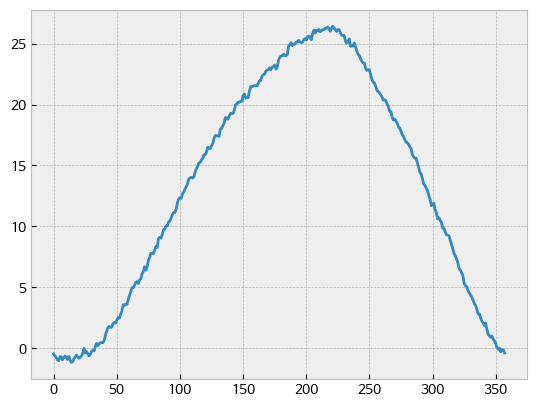

In [51]:
plt.plot(t[0])

In [52]:
answer['평균기온']=t[0]
answer.to_csv('answer.csv',index=False)